# TRY BERTopic 

In [237]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

### Define Path

In [238]:
"""
Define Path
"""

dirpath = os.getcwd()
BASE_PATH = Path(dirpath).parent
print(f"BASE_PATH\t：{BASE_PATH}")
DATA_PATH = os.path.join(BASE_PATH, "data/")
print(f"DATA_PATH\t：{DATA_PATH}")
OUT_PATH = os.path.join(BASE_PATH, "out/")
print(f"OUT_PATH\t：{OUT_PATH}")

BASE_PATH	：/home/masa1357/Dockerdata/gitfile/TRY-BERTopic
DATA_PATH	：/home/masa1357/Dockerdata/gitfile/TRY-BERTopic/data/
OUT_PATH	：/home/masa1357/Dockerdata/gitfile/TRY-BERTopic/out/


### Get Data

In [239]:
import python.datasprit as ds
train, vaild, test = ds.train_test_sprit()

Train shape:  (21661, 7)
Valid shape:  (2708, 7)
Test shape:  (2708, 7)


## Try BERTopic

In [240]:
train = train[train['question_number'] == 1]

In [241]:
train.shape

(6038, 7)

In [242]:
import re, unicodedata

class CleaningData:
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column

    def cleaning(self):
        self.df[self.target_column] = self.df[self.target_column].map(self.remove_extra_spaces)
        self.df[self.target_column] = self.df[self.target_column].map(self.normalize_neologd)

        # クリーニングの過程でtextが空になった行を削除
        self.df = self.df[self.df[self.target_column] != '']
        self.df = self.df[self.df[self.target_column] != '']
        # 文字列が5文字以下の行を削除,「ない，なし」があったら9文字以下でも削除
        self.df = self.df[~((self.df[self.target_column].str.len() <= 9) & ((self.df[self.target_column].str.contains('ない')) | (self.df[self.target_column].str.contains('なし'))))]
        #self.df = self.df[(self.df[self.target_column].str.len() <= 5)]


        self.df = self.df.reset_index()
        return self.df

    def unicode_normalize(self, cls, s):
        pt = re.compile('([{}]+)'.format(cls))

        def norm(c):
            return unicodedata.normalize('NFKC', c) if pt.match(c) else c

        s = ''.join(norm(x) for x in re.split(pt, s))
        s = re.sub('－', '-', s)
        return s

    def remove_extra_spaces(self, s):
        s = re.sub('[ 　]+', ' ', s)
        blocks = ''.join(('\u4E00-\u9FFF',  # CJK UNIFIED IDEOGRAPHS
                          '\u3040-\u309F',  # HIRAGANA
                          '\u30A0-\u30FF',  # KATAKANA
                          '\u3000-\u303F',  # CJK SYMBOLS AND PUNCTUATION
                          '\uFF00-\uFFEF'   # HALFWIDTH AND FULLWIDTH FORMS
                          ))
        basic_latin = '\u0000-\u007F'

        def remove_space_between(cls1, cls2, s):
            p = re.compile('([{}]) ([{}])'.format(cls1, cls2))
            while p.search(s):
                s = p.sub(r'\1\2', s)
            return s

        s = remove_space_between(blocks, blocks, s)
        s = remove_space_between(blocks, basic_latin, s)
        s = remove_space_between(basic_latin, blocks, s)
        return s

    def normalize_neologd(self, s):
        s = s.strip()
        s = self.unicode_normalize('０-９Ａ-Ｚａ-ｚ｡-ﾟ', s)

        def maketrans(f, t):
            return {ord(x): ord(y) for x, y in zip(f, t)}

        s = re.sub('[˗֊‐‑‒–⁃⁻₋−]+', '-', s)  # normalize hyphens
        s = re.sub('[﹣－ｰ—―─━ー]+', 'ー', s)  # normalize choonpus
        s = re.sub('[~∼∾〜〰～]', '', s)  # remove tildes
        s = s.translate(
            maketrans('!"#$%&\'()*+,-./:;<=>?@[¥]^_`{|}~｡､･｢｣',
                  '！”＃＄％＆’（）＊＋，－．／：；＜＝＞？＠［￥］＾＿｀｛｜｝〜。、・「」'))

        s = self.remove_extra_spaces(s)
        s = self.unicode_normalize('！”＃＄％＆’（）＊＋，－．／：；＜＞？＠［￥］＾＿｀｛｜｝〜', s)  # keep ＝,・,「,」
        s = re.sub('[’]', '\'', s)
        s = re.sub('[”]', '"', s)
        return s

    def remove_symbols(self, text):
        text = re.sub(r'[◎, 〇, △, ▲, ×, ◇, □]', '', text)
        return text


In [243]:
cd = CleaningData(train, 'text')
df = cd.cleaning()

In [244]:
df.describe()

,index,course_number,question_number,label
count,6038.000000,6038.000000,6038.0,6038.000000
mean,13596.679861,7.078503,1.0,2.024677
std,7945.122105,4.113045,0.0,1.539783
min,3.000000,1.000000,1.0,0.000000
25%,6610.750000,3.000000,1.0,0.000000
50%,13735.500000,7.000000,1.0,2.000000
75%,20553.250000,11.000000,1.0,4.000000
max,27074.000000,15.000000,1.0,4.000000


In [245]:
import MeCab

def test_mecab(text):
    # MeCabのインスタンスを作成
    tagger = MeCab.Tagger("-r /etc/mecabrc")
    
    # テキストを解析
    result = tagger.parse(text)
    
    # 解析結果を出力
    print("解析結果:")
    print(result)
    
    # print("解析結果の詳細な形式:")
    # print(repr(result))
    
    # 各行を解析して単語と品詞を出力
    print("単語と品詞:")
    for line in result.splitlines()[:-1]:  # EOSを除外
        parts = line.split('\t')
        if len(parts) > 4:
            surface = parts[0]  # 表層形
            # features = parts[1].split(',')
            pos = parts[4]  # 品詞
            print(f"{surface} [{pos}]")

# テスト用のテキスト
test_text = "これはMeCabのテストです。"
test_mecab(test_text)


解析結果:
これ	コレ	コレ	此れ	代名詞			0
は	ワ	ハ	は	助詞-係助詞			
MeCab	MeCab	MeCab	MeCab	名詞-普通名詞-一般			0
の	ノ	ノ	の	助詞-格助詞			
テスト	テスト	テスト	テスト-test	名詞-普通名詞-サ変可能			1
です	デス	デス	です	助動詞	助動詞-デス	終止形-一般	
。			。	補助記号-句点			
EOS

単語と品詞:
これ [代名詞]
は [助詞-係助詞]
MeCab [名詞-普通名詞-一般]
の [助詞-格助詞]
テスト [名詞-普通名詞-サ変可能]
です [助動詞]
。 [補助記号-句点]


In [246]:
import MeCab

class Wakati:
    """ 形態素解析クラス """
    # クラス変数
    MECAB_PATH = "-r /etc/mecabrc"

    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.tagger = MeCab.Tagger(Wakati.MECAB_PATH)

    def wakati_document(self):
        self.df[self.target_column] = self.df[self.target_column].map(self.wakati_sentence)
        return self.df

    def wakati_sentence(self, text):
        words = []
        for c in self.tagger.parse(text).splitlines()[:-1]:
            try:
                parts = c.split('\t')
                if len(parts) > 4:
                    surface = parts[0]  # 表層形
                    pos = parts[4]  # 品詞
                    # print(f"{surface} [{pos}]")
                    if any(pos.startswith(prefix) for prefix in ['名詞', '動詞', '形容詞']):
                        words.append(surface)  # 原型が必要な場合は、適切なインデックスを使う
            except ValueError:  # タブでの分割ができない場合はスキップ
                continue
        return ' '.join(words)


In [247]:
w = Wakati(df, 'text')
df = w.wakati_document()


In [248]:
df["text"].head()

0                    情報 符号 する こと より 情報 短く 伝達 する こと できる
1                      初回 説明 ムー ドル 資料 見 bookroll 使い 学ん
2    確認 テスト いう こと 講義 内容 計算 問題 正誤 問題 マーク 形式 記述 問題 満遍...
3    構造 データ 言語 画像 音声 音楽 処理 つい 例 参考 し 学ん コンピュータ よる パ...
4                               伝える 情報 正確 より する 思っ 難しい
Name: text, dtype: object

In [249]:
df = train

In [250]:
docs = df['text'].tolist()

In [251]:
from bertopic import BERTopic
topic_model = BERTopic(language="japanese", calculate_probabilities=True, verbose=True, nr_topics="20")
topics, probs = topic_model.fit_transform(docs)

2024-04-08 06:50:54,599 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 189/189 [00:49<00:00,  3.82it/s]
2024-04-08 06:51:47,450 - BERTopic - Embedding - Completed ✓
2024-04-08 06:51:47,451 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-08 06:51:52,742 - BERTopic - Dimensionality - Completed ✓
2024-04-08 06:51:52,743 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-08 06:51:54,433 - BERTopic - Cluster - Completed ✓
2024-04-08 06:51:54,434 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-08 06:51:54,605 - BERTopic - Representation - Completed ✓
2024-04-08 06:51:54,606 - BERTopic - Topic reduction - Reducing number of topics
2024-04-08 06:51:54,724 - BERTopic - Topic reduction - Reduced number of topics from 125 to 59


In [252]:
topic_info = topic_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,842,-1_nlogn_logn_log_周波数特性,"[nlogn, logn, log, 周波数特性, br, コモンズ, 統合, ディジタルフ...",[今回はベクトル距離類似度について学んだ複数のデータを扱う時ベクトルを使うと非常に便利になる...
1,0,323,0_情報科学_情報_0と1_授業の進め方の説明,"[情報科学, 情報, 0と1, 授業の進め方の説明, 予習, 文章, 情報科学とは何か, 情...",[情報科学の学習について\r\n情報科学は理科の基礎科目である日本の情報科学は1970年代に...
2,1,310,1_バイ_完全性_暗号について_機密性,"[バイ, 完全性, 暗号について, 機密性, en, 0m, シーザー暗号, 単一換字暗号,...",[暗号とは悪意ある第三者から通信内容を守る技術で計算機やネットワークの発達と普及を背景に暗号...
3,2,289,2_計算_アルゴリズム_問題_コンピュータ,"[計算, アルゴリズム, 問題, コンピュータ, コンピューターサイエンス, cs的アプロー...",[(\r\n問題:数学的に定義された関数(厳密にするべし)\r\n計算:問題事例xが与えられ...
4,3,257,3_符号語同士がs_2k_ハミング距離_符号語同士が2t,"[符号語同士がs, 2k, ハミング距離, 符号語同士が2t, 反転確率, 符号語どうしがs...",[情報を送るときにノイズが発生してしまうがそれではもとの情報が書き換えられてしまう(ビット列...


In [253]:
topic_info.to_csv(OUT_PATH + 'topic_info.csv', index=False)

In [254]:
# トピックとドキュメントのペアを作成
topic_doc_pairs = [(topic, doc) for topic, doc in zip(topics, docs)]

# データフレームを作成
df_topic_docs = pd.DataFrame(topic_doc_pairs, columns=['Topic', 'Document'])

# CSVファイルに保存
df_topic_docs.to_csv('topic_documents.csv', index=False)

In [255]:
topic_model.visualize_topics()

In [256]:
topic_model.visualize_hierarchy()

In [257]:
# トピックと真のラベルの関連をデータフレームで表現
df_topics_labels = pd.DataFrame({'Topic': topics, 'True_Label': df['label']})

# 各トピックにおけるラベルの分布を集計
label_distribution = df_topics_labels.groupby('Topic')['True_Label'].value_counts().unstack().fillna(0)

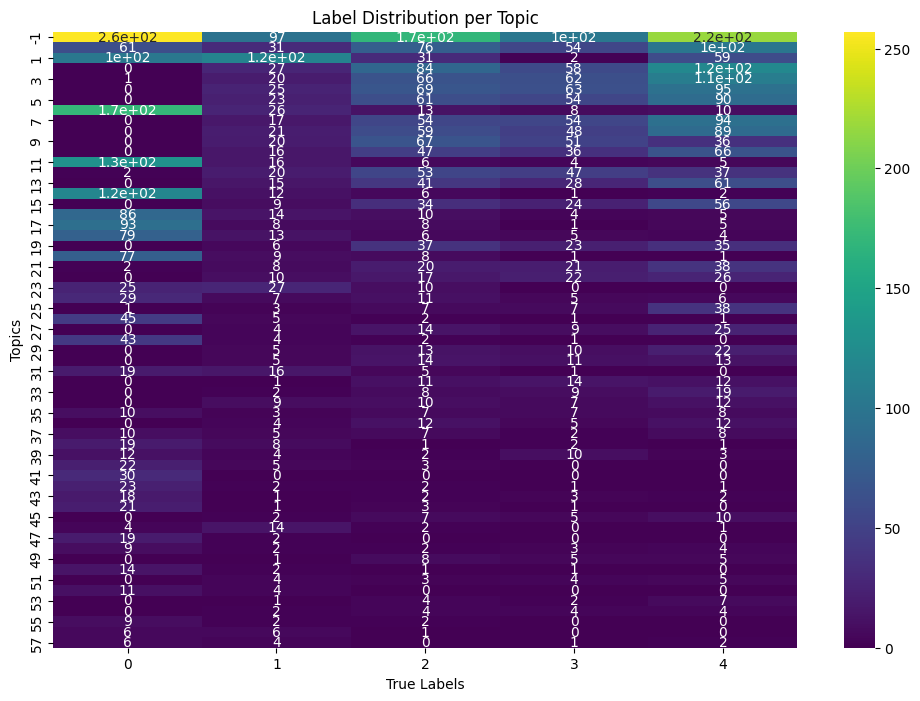

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# 結果を視覚化
plt.figure(figsize=(12, 8))
sns.heatmap(label_distribution, annot=True, cmap='viridis')
plt.title('Label Distribution per Topic')
plt.xlabel('True Labels')
plt.ylabel('Topics')
plt.show()

In [259]:
# import plotly.graph_objects as go

# # トピックと真のラベルの関連をデータフレームで表現
# df_topics_labels = pd.DataFrame({'Topic': topics, 'True_Label': train['label']})

# # 各トピックにおけるラベルの分布を集計
# label_distribution = df_topics_labels.groupby('Topic')['True_Label'].value_counts().unstack().fillna(0)

# # Plotlyの棒グラフを作成
# fig = go.Figure()

# # トピックごとの棒グラフを作成
# for topic in label_distribution.index:
#     fig.add_trace(
#         go.Bar(
#             x=label_distribution.columns,
#             y=label_distribution.loc[topic],
#             name=f"Topic {topic}"
#         )
#     )

# # シークバーの設定
# steps = []
# for i in range(len(label_distribution.index)):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(label_distribution.index)},
#               {"title": f"Topic {label_distribution.index[i]}"}],
#         label=f"Topic {label_distribution.index[i]}"
#     )
#     step["args"][0]["visible"][i] = True  # このトピックのバーだけを表示
#     steps.append(step)

# sliders = [dict(
#     active=0,
#     currentvalue={"prefix": "Selected Topic: "},
#     pad={"t": 50},
#     steps=steps
# )]

# fig.update_layout(
#     sliders=sliders,
#     title="Label Distribution per Topic",
#     xaxis_title="True Labels",
#     yaxis_title="Count"
# )

# fig.show()


In [260]:
# すべての文書に対してトピック割り当てを行う
topics, _ = topic_model.transform(docs)

# トピック1に割り当てられた文書のインデックスを取得
topic_1_indices = [i for i, topic in enumerate(topics) if topic == 1]

# トピック1に割り当てられた文書を抽出
topic_1_docs = [docs[i] for i in topic_1_indices]

# トピック1に割り当てられた文書を表示または保存
# for doc in topic_1_docs:
#     print(doc)


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

Batches: 100%|██████████| 189/189 [00:49<00:00,  3.79it/s]
2024-04-08 06:52:46,685 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-04-08 06:52:46,701 - BERTopic - Dimensionality - Completed ✓
2024-04-08 06:52:46,701 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-04-08 06:52:46,905 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-04-08 06:52:49,314 - BERTopic - Probabilities - Completed ✓
2024-04-08 06:52:49,315 - BERTopic - Cluster - Completed ✓


In [261]:
topic_model.visualize_hierarchy()

In [262]:
import plotly.graph_objects as go

# トピックと真のラベルの関連をデータフレームで表現
df_topics_labels = pd.DataFrame({'Topic': topics, 'True_Label': train['label']})

# 各トピックにおけるラベルの分布を集計
label_distribution = df_topics_labels.groupby('Topic')['True_Label'].value_counts().unstack().fillna(0)

# Plotlyの棒グラフを作成
fig = go.Figure()

# トピックごとの棒グラフを作成
for topic in label_distribution.index:
    fig.add_trace(
        go.Bar(
            x=label_distribution.columns,
            y=label_distribution.loc[topic],
            name=f"Topic {topic}"
        )
    )

# シークバーの設定
steps = []
for i in range(len(label_distribution.index)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(label_distribution.index)},
              {"title": f"Topic {label_distribution.index[i]}"}],
        label=f"Topic {label_distribution.index[i]}"
    )
    step["args"][0]["visible"][i] = True  # このトピックのバーだけを表示
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Selected Topic: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Label Distribution per Topic",
    xaxis_title="True Labels",
    yaxis_title="Count"
)

fig.show()


In [264]:
import csv

# BERTopicからトピック情報を取得
topic_info = topic_model.get_topic_info()

# トピック番号と題名の対応を辞書で取得
topic_names = topic_info.set_index('Topic')['Name'].to_dict()

# トピックごとに文書をフィルタリングしてCSVファイルに保存
for topic_number in set(topics):
    # トピック番号に一致する文書をフィルタリング
    topic_docs = [doc for doc, topic in zip(docs, topics) if topic == topic_number]
    
    # トピックに対応する文書のデータフレームを作成
    df = pd.DataFrame(topic_docs, columns=['Document'])
    
    # トピックの題名をデータフレームに追加
    df['Topic Name'] = topic_names.get(topic_number, 'Unknown Topic')
    
    # CSVファイルに保存
    file_name = f'{OUT_PATH}/all_topics/topic_{topic_number}.csv'
    df.to_csv(file_name, index=False, quoting=csv.QUOTE_ALL)